(insert image here later!!!)

# Analysis of Real Estate Prices and Features in King County, Seattle 

## Overview

Recommendations:

- 1
- 2
- 3

## Business Problem

A real estate agency is looking to provide advice to homeowners looking to increase the values of their homes. We are seeking to identify several variables that can **predict** what a home's sale price can be.

**Alternately:** If a customer is looking to purchase land without a house already on the lot, our recommendations will help home builders maximize their profits by helping builders identify which predictor variables to focus on.

## Importing Packages and Libraries

In [182]:
# baseline analysis and visualization
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sci-kit learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# from random import gauss
# from mpl_toolkits.mplot3d import Axes3D

# statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

...and some formatting options.

In [183]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Below, we read in the data and check out some of its basic features: column names, null values, data types, etc.

In [184]:
# Reading in .csv file, creating initial pandas dataframe
df = pd.read_csv('data/kc_house_data.csv')

In [185]:
# Listing out column names
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [186]:
# Checking datatypes and null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Columns currently coded as datatype `object` include...
- `date`
- `waterfront`
- `view`
- `condition`
- `grade`
- `sqft_basement`

Columns with null values:
- `waterfront`
- `view`
- `yr_renovated`

In [187]:
# Descriptive statistics for numerical columns
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


## Basic data cleaning

First, we convert the column `date` to a more usable format; the code below transforms the column to type `datetime64[ns]`.

In [188]:
# Converting column `date` to datetime64[ns] from type string/object
df['date'] = df['date'].astype('datetime64[ns]')

Every house has a unique `id` value, but does every row in the dataset represent a **unique house?**

In [189]:
# Check for multiples in column `id`
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

Looks like we have a few houses with more than one sale on record! Let's examine one of the `id` values.

In [190]:
df.loc[df['id'] == 795000620]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17588,795000620,2014-09-24,115000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5 Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17589,795000620,2014-12-15,124000.00,3,1.00,1080,6250,1.00,NO,NONE,Fair,5 Fair,1080,0.0,1950,0.00,98168,47.50,-122.33,1070,6250
17590,795000620,2015-03-11,157000.00,3,1.00,1080,6250,1.00,NaN,NONE,Fair,5 Fair,1080,0.0,1950,nan,98168,47.50,-122.33,1070,6250


Okay, so the most recent sale on record - which took place on March 11, 2015 - has the highest value in the `price` column! We might infer from this that the value of the house increased over time, despite no changes in what values are stored in the other columns.

What about other homes with more than one sale on record?

In [191]:
df.loc[df['id'] == 1825069031]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3946,1825069031,2014-08-14,550000.00,4,1.75,2410,8447,2.00,NO,GOOD,Good,8 Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789
3947,1825069031,2014-10-16,550000.00,4,1.75,2410,8447,2.00,NaN,GOOD,Good,8 Good,2060,350.0,1936,1980.00,98074,47.65,-122.09,2520,14789


In [192]:
df.loc[df['id'] == 2019200220]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12942,2019200220,2014-09-23,160000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7 Average,1160,310.0,1985,0.00,98003,47.27,-122.30,1670,8359
12943,2019200220,2015-02-26,269000.00,3,2.25,1470,8682,1.00,NO,NONE,Average,7 Average,1160,310.0,1985,nan,98003,47.27,-122.30,1670,8359


The price remained the same for the property with `id` value `1825069031`, but **increased** again in the second `id` value we checked. It might be best to keep the **most recent** sale on record to avoid adding any additional 'noise' to our model.

In [193]:
df.drop_duplicates(subset=['id'], keep='last', inplace=True)

Let's make sure that worked...

In [194]:
len(df['id'].unique()) == len(df)

True

In [195]:
# Dropping `id` column now that we know we have all
# unique values for `id`

df.drop(labels = 'id',
        axis = 1,
        inplace = True)

**Something else that might be of note:** in some of these rows where the same `id` appears twice, a value that *was* recorded in the first sale appears as a *null value* in a later sale, e.g. the `waterfront` column on the house whose `id` is `1825069031`.

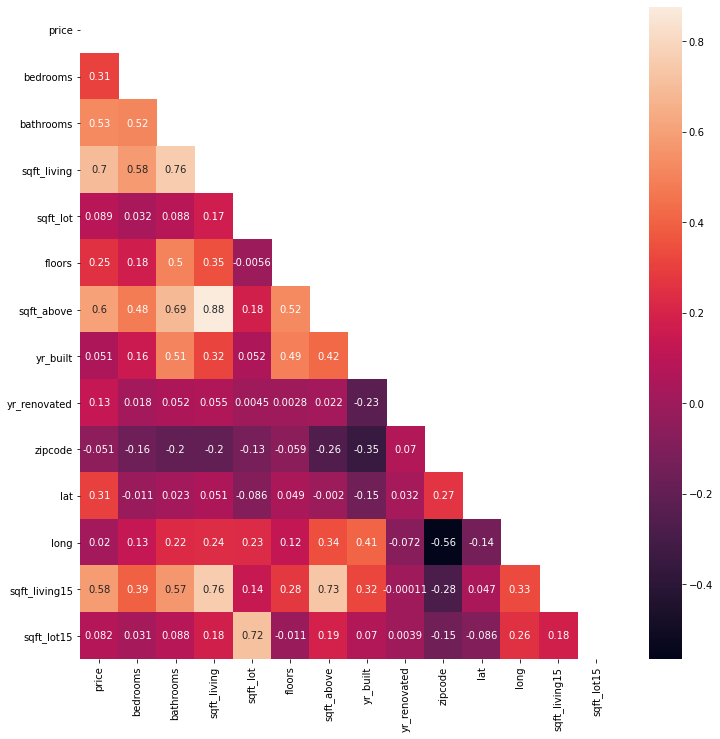

In [196]:
# Visualizing correlations between numerical columns
# with a seaborn heatmap to investigate the correlation
# of various features w/ `price` and assess multicollinearity

fig, ax = plt.subplots(figsize=(12,12))
corr = df.corr()

# Instantiate numpy array of zeroes and assign to `mask`
mask = np.zeros_like(corr,
                     dtype=bool)

# Returns indices from upper triangle of array 
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            annot = True,
            mask = mask);

#### Observations from this heatmap:

- `sqft_living` has the highest correlation with price, an r-value of `0.7`...
    - ...but `sqft_living` is also correlated with several other columns: `bedrooms`, `bathrooms`, `sqft_above` (this one has an r-value of `0.88`!), and `sqft_living15`, so we'll need to be careful that we don't include collinear features in our models.
- `zipcode`, `lat`, and `long` all have low (0.31 or below) correlations with `price` - these columns likely won't be useful to us in constructing models for this project, but could be worth looking into as next-step recommendations.

In [197]:
# Creating copy of original dataframe before dropping columns
df_copy = df.copy()

In [199]:
# Drop irrelevant columns
df_copy.drop(columns = ['date',
                        'floors',
                        'waterfront',
                        'condition',
                        'sqft_above',
                        'sqft_basement',
                        'yr_renovated',
                        'lat',
                        'long',
                        'sqft_living15',
                        'sqft_lot15'],
                        inplace=True)

In [200]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21420 non-null  float64
 1   bedrooms     21420 non-null  int64  
 2   bathrooms    21420 non-null  float64
 3   sqft_living  21420 non-null  int64  
 4   sqft_lot     21420 non-null  int64  
 5   view         21357 non-null  object 
 6   grade        21420 non-null  object 
 7   yr_built     21420 non-null  int64  
 8   zipcode      21420 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


In [218]:
# Dropping nulls from column `view`
df_copy = df_copy.dropna(subset = ['view'])

In [227]:
# Checking out the frequency of each possible value
# for column `grade`
df_copy['grade'].value_counts()

7 Average        8863
8 Good           6029
9 Better         2595
6 Low Average    1988
10 Very Good     1126
11 Excellent      394
5 Fair            234
12 Luxury          87
4 Low              27
13 Mansion         13
Name: grade, dtype: int64

Only **one row** where the `grade` value, i.e. the quality of materials used in building the house, is equal to `3 Poor`. We drop this column to eliminate an outlier.

In [219]:
# Dropping the single row where `grade` is equal to
# `3 Poor`, in order to eliminate an outlier
df_copy = df_copy[df_copy['grade'] != '3 Poor']

In [220]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21356 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21356 non-null  float64
 1   bedrooms     21356 non-null  int64  
 2   bathrooms    21356 non-null  float64
 3   sqft_living  21356 non-null  int64  
 4   sqft_lot     21356 non-null  int64  
 5   view         21356 non-null  object 
 6   grade        21356 non-null  object 
 7   yr_built     21356 non-null  int64  
 8   zipcode      21356 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


## Splitting data into train and test sets

Our **target** variable, or `X`, is going to be `price`, i.e. the sale price of a given home.

In [221]:
# Creating target variable and predictor dataframe
y = df_copy['price']
X = df_copy.drop(labels = 'price',
                 axis = 1)

In [222]:
# Initiating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [223]:
# Check out `X_train`
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14308 entries, 1215 to 15997
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     14308 non-null  int64  
 1   bathrooms    14308 non-null  float64
 2   sqft_living  14308 non-null  int64  
 3   sqft_lot     14308 non-null  int64  
 4   view         14308 non-null  object 
 5   grade        14308 non-null  object 
 6   yr_built     14308 non-null  int64  
 7   zipcode      14308 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 1006.0+ KB


In [224]:
X_train.shape[0] == y_train.shape[0]

True

In [225]:
X_test.shape[0] == y_test.shape[0]

True

In [226]:
# Creating concatenated dataframes
train_df = pd.concat([X_train, y_train], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)

Below, we group the dataset by column `view` and get some descriptive statistics on the column.

In [146]:
# df_copy.groupby('view').mean()
# df_copy.sort_values('price', ascending = False).head()

In [47]:
# df_copy['grade'].value_counts()

In [48]:
# fig, ax = plt.subplots(figsize=(20,10))

# sns.histplot(df_copy['grade'])

In [52]:
# fig, ax = plt.subplots(figsize=(8,8))
# heat = sns.heatmap(train_df.corr(), annot = True)

### View Analysis

is there a difference between those that have a view versus those that don't

In [53]:
summary_of_view = df_copy.groupby('view').agg(['mean', 'std'])

summary_of_view

price           sqft_living        
                mean       std        mean     std
view                                              
AVERAGE    791956.68 510351.93     2651.20 1133.59
EXCELLENT 1454416.19 934214.96     3337.17 1544.93
FAIR       814386.56 513226.70     2573.51 1042.89
GOOD       972849.27 615076.79     3012.47 1204.88
NONE       498336.32 287341.26     2001.17  837.19

Observations from this summary:

- Significant gap between `EXCELLENT` and `GOOD`
- Smallest gap is between `FAIR` and `AVERAGE` - we'll need to determine if this difference is a signficant one.

From the df summary, we notice that there is a difference in price between price for those that are excellent
compared to those that have a view written as none. Further investigation will be performed to determine if this
difference is statistically significant

In [54]:
# Figure out how to do this in a loop/function?
df_average = train_df[train_df['view'] == 'AVERAGE']
df_excellent = train_df[train_df['view'] == 'EXCELLENT']
df_fair = train_df[train_df['view'] == 'FAIR']
df_good = train_df[train_df['view'] == 'GOOD']
df_none = train_df[train_df['view'] == 'NONE']

In [55]:
train_df['view'].value_counts()

NONE         12900
AVERAGE        624
GOOD           353
FAIR           220
EXCELLENT      212
Name: view, dtype: int64

Subsetting the data into different views
 - Number of rows:
     - `NONE` = 12906
     - `AVERAGE` = 636
     - `GOOD` = 342
     - `FAIR` = 213
     - `EXCELLENT` = 212

In [56]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [57]:
#creating df of just view
# df_view = train_df[['view', 'price']]

#Tukey test
#print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

`AVERAGE` and `FAIR` are not significant to each other, so they should be grouped together. Each other subset should be on their own as they have a p value of < .05

#### Grade Analysis

 Is there a difference between grades

In [58]:
train_df.grade.value_counts()

7 Average        5928
8 Good           4031
9 Better         1754
6 Low Average    1329
10 Very Good      772
11 Excellent      275
5 Fair            168
12 Luxury          71
4 Low              13
13 Mansion         10
Name: grade, dtype: int64

Issues that may be present here:
- Only a single record for `grade` value of `3 Poor`
- `grade` is type `object`, so we'll need to convert it in the encoding process.

In [59]:
# Dropping poor row, since there is only one
df3 = train_df.copy()
df3 = df3[df3['grade'] != '3 Poor']

In [60]:
df3.grade = [x.replace(" ", "_").strip() for x in df3.grade]

In [61]:
df3['grade'].value_counts()

7_Average        5928
8_Good           4031
9_Better         1754
6_Low_Average    1329
10_Very_Good      772
11_Excellent      275
5_Fair            168
12_Luxury          71
4_Low              13
13_Mansion         10
Name: grade, dtype: int64

In [62]:
# Might need a for loop or a function here
df_10 = train_df[train_df['grade'] == '10 Very Good']
df_11 = train_df[train_df['grade'] == '11 Excellent']
df_12 = train_df[train_df['grade'] == '12 Luxury']
df_4 = train_df[train_df['grade'] == '4 Low']
df_5 = train_df[train_df['grade'] == '5 Fair']
df_6 = train_df[train_df['grade'] == '6 Low Average']
df_7 = train_df[train_df['grade'] == '7 Average']
df_8 = train_df[train_df['grade'] == '8 Good']
df_9 = train_df[train_df['grade'] == '9 Better']

In [63]:
# Finding f-statistic and p-value using ANOVA testing

f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'], df_12['price'],
                                              df_4['price'], df_5['price'], df_6['price'],
                                              df_7['price'], df_8['price'], df_9['price'])
p_value_grade

0.0

This 0.0 value indicates there is significance **somewhere** between `grade` values, but additional testing is required to determine **where** exactly this significance exists.

There is a significant difference in price betweeen grades but we don't know which one is significant.
Further testing required to determine which is important

In [64]:
# Ad-hoc test to determine differeces in price vs. grade

df_grade = train_df[['grade', 'price']]

print(pairwise_tukeyhsd(df_grade['price'], df_grade['grade']))

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1        group2       meandiff   p-adj      lower         upper     reject
-----------------------------------------------------------------------------------
 10 Very Good  11 Excellent   428504.7027  0.001   371514.9886   485494.4167   True
 10 Very Good     12 Luxury  1142452.3959  0.001  1041811.5921  1243093.1997   True
 10 Very Good    13 Mansion   2678649.579  0.001  2420368.3406  2936930.8175   True
 10 Very Good         4 Low  -862119.6518  0.001 -1089081.3832  -635157.9203   True
 10 Very Good        5 Fair  -806482.5281  0.001  -875569.9155  -737395.1408   True
 10 Very Good 6 Low Average  -746671.4398  0.001  -783394.5976  -709948.2819   True
 10 Very Good     7 Average  -648553.9836  0.001  -679604.7831   -617503.184   True
 10 Very Good        8 Good  -510946.9293  0.001  -542828.4757  -479065.3829   True
 10 Very Good      9 Better  -281534.5048  0.001  -316584.7743  -246484.2352

Summary of what we notice

#### One Hot Encoding | Rework to include Train only

In [65]:
#categorizing average and fair together since they are not different from each other
df3['view'] = df3['view'].str.replace('AVERAGE', 'FAIR')

In [66]:
#making the categorical variable
cate_column = df3[['grade', 'view']]

cate_column

,grade,view
16334,9_Better,FAIR
3057,7_Average,NONE
12737,7_Average,NONE
1623,6_Low_Average,NONE
6434,7_Average,NONE
...,...,...
11383,8_Good,NONE
12069,7_Average,GOOD
5432,6_Low_Average,NONE
868,7_Average,NONE


In [67]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

<14351x13 sparse matrix of type '<class 'numpy.float64'>'
	with 27718 stored elements in Compressed Sparse Row format>

In [68]:
name = ohe.get_feature_names_out()

In [69]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name, index = features.index)
cate_parsed

,grade_11_Excellent,grade_12_Luxury,grade_13_Mansion,grade_4_Low,grade_5_Fair,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,view_FAIR,view_GOOD,view_NONE,view_nan
16334,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
3057,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
12737,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1623,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
6434,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11383,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
12069,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
5432,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
868,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


### Scaling | Rework only to include train

In [70]:
# Creating dataframe with only numerical columns
numbers = train_df.select_dtypes(np.number)

In [71]:
#Rework to include only the train_df
ss = StandardScaler()

columns_name1 = ['price', 'sqft_living']
numbers_scaling = numbers.copy()

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

,sqft_living,price
16334,2.06,2.58
3057,0.01,-0.31
12737,-0.31,-0.53
1623,-0.80,-0.94
6434,-0.57,0.14
...,...,...
11383,0.44,-0.72
12069,0.42,0.15
5432,-0.89,-0.54
868,-0.82,-0.43


In [72]:
#combinig scale and ohe
scaled_and_parse_df = pd.concat([numbers_scaling, cate_parsed], axis = 1)

In [73]:
scaled_and_parse_df.columns = [x.replace(" ", "_").strip() for x in scaled_and_parse_df.columns]

## Linear Regression | Rework so fit is only on train and not test

#### simple linear

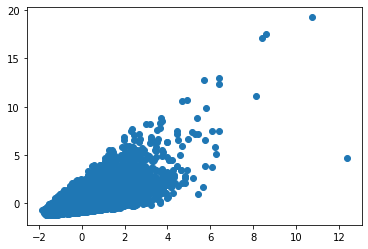

In [74]:
fig, ax = plt.subplots()

x = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']


ax.scatter(x, y);

In [75]:
np.corrcoef(df['sqft_living'],df['price'])

array([[1.        , 0.70129486],
       [0.70129486, 1.        ]])

Passing our first assumption: Based on our scatterplot, we can see that there is a strong correlation between `sqft_living` and price. Our pearson correlation coefficiant of `.70` suggests that these two variables are strongly correlated. Refer to the heatmap above re: multicollinearity.

In [76]:
# Baseline model
# Import necessary package
from sklearn.dummy import DummyRegressor

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']

# Fit
dummy_lr.fit(X,y)

# Score
dummy_lr.score(X,y)

0.0

In [77]:
#Define X and y variable using scaled & parse dataframe

X_s_p = scaled_and_parse_df[['sqft_living']]
y_s_p = scaled_and_parse_df[['price']]

In [78]:
sk_lr = LinearRegression()
sk_lr.fit(X_s_p, y_s_p)
preds = sk_lr.predict(y_s_p)

preds

C:\Users\toast\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price
Feature names seen at fit time, yet now missing:
- sqft_living

  warnings.warn(message, FutureWarning)


array([[ 1.81345571],
       [-0.22132495],
       [-0.37359517],
       ...,
       [-0.378327  ],
       [-0.30421522],
       [ 0.58318044]])

In [79]:
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df[['price']]

In [80]:
resids = y - preds
resids

,price
16334,0.77
3057,-0.09
12737,-0.16
1623,-0.28
6434,0.04
...,...
11383,-0.21
12069,0.04
5432,-0.16
868,-0.13


In [81]:
#Create out bins

bins = int( len(X)**.5)
bins

119

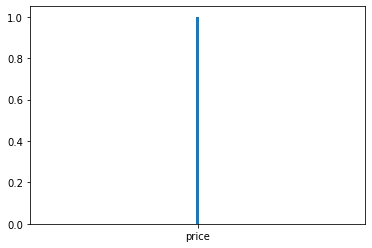

In [82]:
# Histogram of residuals

plt.hist(resids, bins=bins);

In [83]:
print(resids.max())
resids.min()

price   5.73
dtype: float64


price   -0.37
dtype: float64

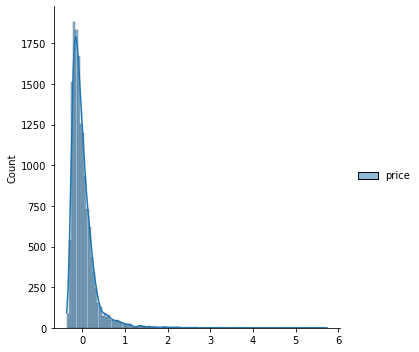

In [84]:
sns.displot(resids, bins=bins, kde=True)

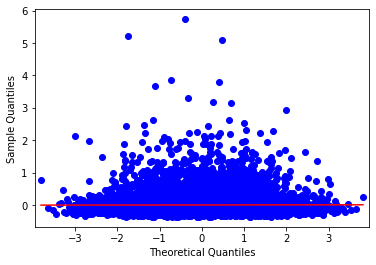

In [85]:
sm.qqplot(resids, line='r');

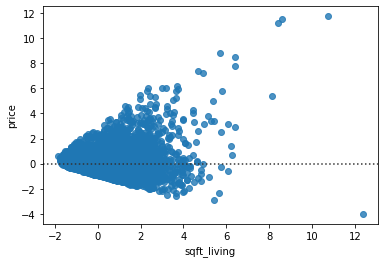

In [86]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

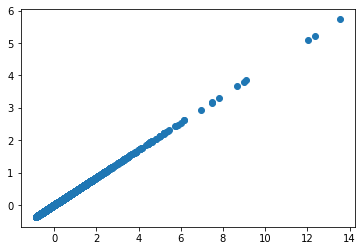

In [87]:
plt.scatter(preds, resids);

In [88]:
#Fit the dummy_regressor

dummy_lr.fit(X_s_p,y_s_p)

DummyRegressor()

In [89]:
# Score it

dummy_lr.score(X_s_p,y_s_p)

0.0

In [90]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula,
                   data = scaled_and_parse_df).fit()
simple_mod_summ = simple_model.summary()

simple_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.400e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:03   Log-Likelihood:                -15478.
No. Observations:               14351   AIC:                         3.096e+04
Df Residuals:                   14349   BIC:                         3.098e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.557e-16      0.006   2.62e-14      1.000      -0.012       0.012
sqft_living     0.7027      0.006    118.304      0.000       0.691       0.714
==============================================================================
Omnibus:                    10523.549   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491295.599
Skew:                           3.036   Prob(JB):                         0.00
Kurtosis:                      31.013   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
#test on our test data set

Summary comparison between the two

#### Multiple regression | Rework to train data

Slowly adding in other variables

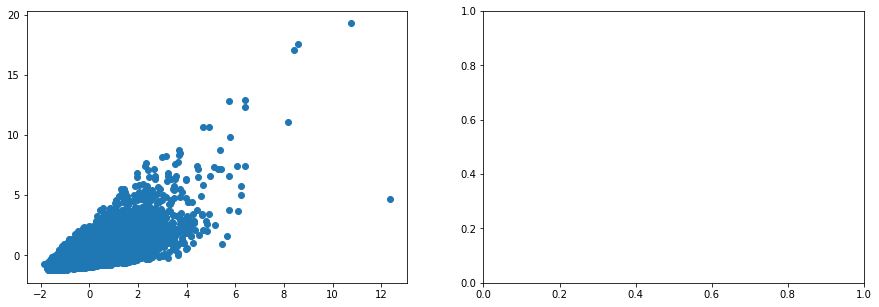

In [92]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

x1 = scaled_and_parse_df[['sqft_living']]
y1 = scaled_and_parse_df[['price']]

# x2 = scaled_and_parse_df[['bedrooms']]

ax[0].scatter(x1, y1)
# ax[1].scatter(x2,y1);

#Upon looking at our scaled dataframe, we noticed that there is a house sold with 33 bedrooms for $600k
#After considering the price sold, sqft and number of bathrooms - the # of bedrooms appears 
#to be an error of somesort
#Since we explored bedrooms having a relatively small correlation to price, we are not too worried about this one
#outlier being included in our scatterplot

In [93]:
simple_formula3 = 'price ~ sqft_living'
simple_model3 = ols(formula = simple_formula3,
                   data = scaled_and_parse_df).fit()
simple_mod_summ3 = simple_model3.summary()

simple_mod_summ3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.400e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:03   Log-Likelihood:                -15478.
No. Observations:               14351   AIC:                         3.096e+04
Df Residuals:                   14349   BIC:                         3.098e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.557e-16      0.006   2.62e-14      1.000      -0.012       0.012
sqft_living     0.7027      0.006    118.304      0.000       0.691       0.714
==============================================================================
Omnibus:                    10523.549   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491295.599
Skew:                           3.036   Prob(JB):                         0.00
Kurtosis:                      31.013   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
scaled_and_parse_df.head()

,sqft_living,price,grade_11_Excellent,grade_12_Luxury,grade_13_Mansion,grade_4_Low,grade_5_Fair,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,view_FAIR,view_GOOD,view_NONE,view_nan
16334,2.06,2.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
3057,0.01,-0.31,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
12737,-0.31,-0.53,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1623,-0.80,-0.94,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
6434,-0.57,0.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


In [95]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1791.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:03   Log-Likelihood:                -13442.
No. Observations:               14351   AIC:                         2.691e+04
Df Residuals:                   14337   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9292      0.046     41.910      0.000       1.839       2.019
sqft_living             0.3568      0.008     43.305      0.000       0.341       0.373
view_FAIR              -0.9072      0.044    -20.411      0.000      -0.994      -0.820
view_GOOD              -0.7239      0.051    -14.211      0.000      -0.824      -0.624
view_NONE              -1.2360      0.040    -30.975      0.000      -1.314      -1.158
grade_11_Excellent      0.7162      0.044     16.220      0.000       0.630       0.803
grade_12_Luxury         2.0510      0.079     26.016      0.000       1.897       2.206
grade_13_Mansion        5.4528      0.199     27.341      0.000       5.062       5.844
grade_4_Low            -1.1296      0.174     -6.473      0.000      -1.472      -0.788
grade_5_Fair           -1.1148      0.057    -19.578      0.000      -1.226      -1.003
grade_6_Low_Average    -1.0134      0.034    -29.399      0.000      -1.081      -0.946
grade_7_Average        -0.9382      0.028    -32.951      0.000      -0.994      -0.882
grade_8_Good           -0.7860      0.027    -29.258      0.000      -0.839      -0.733
grade_9_Better         -0.4775      0.027    -17.536      0.000      -0.531      -0.424
==============================================================================
Omnibus:                     9642.745   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           493469.402
Skew:                           2.616   Prob(JB):                         0.00
Kurtosis:                      31.247   Cond. No.                         56.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above model has an adjusted R-squared value of 0.623 suggesting that this model accounts for roughly ~10-15% more variance.

In [96]:
simple_formula4 = 'price ~ view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     1577.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:04   Log-Likelihood:                -14324.
No. Observations:               14351   AIC:                         2.867e+04
Df Residuals:                   14338   BIC:                         2.877e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.5776      0.046     55.689      0.000       2.487       2.668
view_FAIR              -0.9657      0.047    -20.442      0.000      -1.058      -0.873
view_GOOD              -0.7309      0.054    -13.494      0.000      -0.837      -0.625
view_NONE              -1.3720      0.042    -32.436      0.000      -1.455      -1.289
grade_11_Excellent      1.0559      0.046     22.850      0.000       0.965       1.146
grade_12_Luxury         2.7972      0.082     34.193      0.000       2.637       2.958
grade_13_Mansion        6.8573      0.209     32.771      0.000       6.447       7.267
grade_4_Low            -2.1867      0.184    -11.902      0.000      -2.547      -1.827
grade_5_Fair           -2.0508      0.056    -36.609      0.000      -2.161      -1.941
grade_6_Low_Average    -1.8736      0.030    -62.546      0.000      -1.932      -1.815
grade_7_Average        -1.6094      0.025    -63.361      0.000      -1.659      -1.560
grade_8_Good           -1.2729      0.026    -49.060      0.000      -1.324      -1.222
grade_9_Better         -0.7080      0.028    -24.929      0.000      -0.764      -0.652
==============================================================================
Omnibus:                    11104.890   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           862079.194
Skew:                           3.124   Prob(JB):                         0.00
Kurtosis:                      40.452   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
simple_formula4 = 'price ~ sqft_living + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     2019.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:04   Log-Likelihood:                -14057.
No. Observations:               14351   AIC:                         2.814e+04
Df Residuals:                   14340   BIC:                         2.822e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7801      0.027     29.421      0.000       0.728       0.832
sqft_living             0.3931      0.009     46.130      0.000       0.376       0.410
grade_11_Excellent      0.7633      0.046     16.572      0.000       0.673       0.854
grade_12_Luxury         2.2195      0.082     27.041      0.000       2.059       2.380
grade_13_Mansion        5.6115      0.208     26.966      0.000       5.204       6.019
grade_4_Low            -1.1365      0.182     -6.241      0.000      -1.493      -0.780
grade_5_Fair           -1.1206      0.059    -18.856      0.000      -1.237      -1.004
grade_6_Low_Average    -1.0408      0.036    -28.939      0.000      -1.111      -0.970
grade_7_Average        -0.9852      0.030    -33.189      0.000      -1.043      -0.927
grade_8_Good           -0.8238      0.028    -29.406      0.000      -0.879      -0.769
grade_9_Better         -0.4972      0.028    -17.501      0.000      -0.553      -0.442
==============================================================================
Omnibus:                     9947.813   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           449076.273
Skew:                           2.790   Prob(JB):                         0.00
Kurtosis:                      29.830   Cond. No.                         44.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD +view_NONE'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     4171.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:51:04   Log-Likelihood:                -14827.
No. Observations:               14351   AIC:                         2.966e+04
Df Residuals:                   14346   BIC:                         2.970e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3369      0.043     30.920      0.000       1.252       1.422
sqft_living     0.6463      0.006    109.335      0.000       0.635       0.658
view_FAIR      -1.0275      0.049    -21.059      0.000      -1.123      -0.932
view_GOOD      -0.8214      0.056    -14.677      0.000      -0.931      -0.712
view_NONE      -1.3976      0.044    -31.954      0.000      -1.483      -1.312
==============================================================================
Omnibus:                    10091.069   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           503842.330
Skew:                           2.818   Prob(JB):                         0.00
Kurtosis:                      31.475   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that our model is the strongest when we are comparing `sqft_living` + `view` + `grade` with an adjusted R-squared of 0.623.


## Next Steps:

- `bathrooms` and `bedrooms` - they are collinear with variables like `sqft_living`, which prevented us from including them in our model, but they might be useful avenues for further exploration.
- `waterfront` - our EDA demonstrated a significant difference in `price` between homes with waterfront views vs. homes without; it may be worth further exploring what development opportunities exist in waterfront areas.
- `zipcode` - taking a look at what neighborhoods/geographic areas yield high sale prices.
    - Look at interaction items: if homes with `EXCELLENT` views are concentrated in certain areas, perhaps.